---
title: More on Bayesian Regularization
---

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import cvxpy as cp

Let us consider the temperature anomalies dataset that we used in the last couple of lectures. 

   Year  Anomaly
0  1850    -0.46
1  1851    -0.17
2  1852    -0.02
3  1853    -0.12
4  1854    -0.28


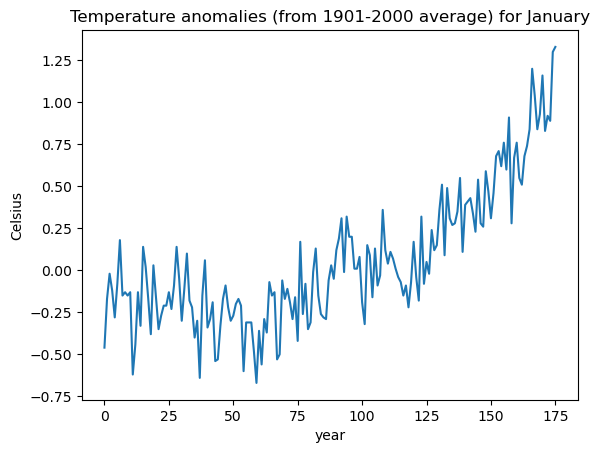

In [113]:
temp_jan = pd.read_csv('TempAnomalies_January.csv', skiprows=4)
print(temp_jan.head())
y = temp_jan['Anomaly']
plt.plot(y)
plt.xlabel('year')
plt.ylabel('Celsius')
plt.title('Temperature anomalies (from 1901-2000 average) for January')
plt.show()

We will fit our high-dimensional regression model: 
\begin{align*}
  y_t = \beta_0 + \beta_1 (t - 1) + \beta_2 (t - 2)_+ + \dots + \beta_{n-1}(t - (n-1))_+ + \epsilon_t
\end{align*}
to this dataset. This can be written in the usual regression form as $y = X \beta + \epsilon$ with the $X$ matrix calculated as follows. 

In [114]:
n = len(y)
x = np.arange(1, n+1)
X = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float))*(x-c)
    X = np.column_stack([X, xc])
print(X)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 173. 172. ...   1.   0.  -0.]
 [  1. 174. 173. ...   2.   1.   0.]
 [  1. 175. 174. ...   3.   2.   1.]]


### Quick Recap: Ridge Regularization (Lecture 11)

The estimator is given by the minimizer of: 
\begin{align*}
   \|y - X \beta\|^2 + \lambda \sum_{j=2}^{n-1} \beta_j^2
\end{align*}
where $\lambda$ is the tuning parameter. Small $\lambda$ leads to fitted values close to the data (overfitting) and large $\lambda$ leads to fitted values coming from a straight line (underfitting). We used the following code for computing the ridge estimator for fixed $\lambda$ (note that, instead of using this code, we can also use the formula derived in Lecture 12: $(X^T X + \lambda J)^{-1} X^T y$ to compute the ridge estimator). 


In [116]:
def solve_ridge(X, y, lambda_val, penalty_start=2):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value


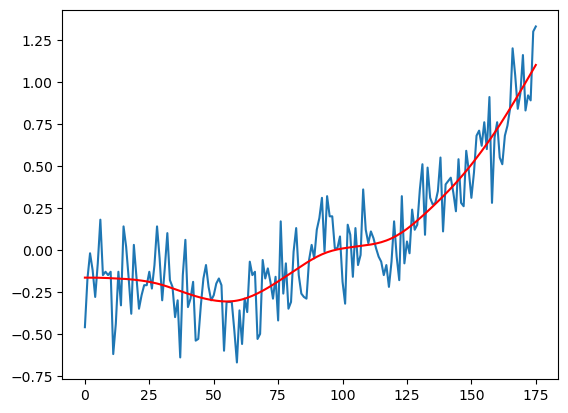

In [120]:
b_ridge = solve_ridge(X, y, lambda_val = 1e4) #also try 1e-4, 1e8 etc.
plt.plot(y)
ridge_fitted = np.dot(X, b_ridge)
plt.plot(ridge_fitted, color = 'red')
plt.show()

To choose $\lambda$, we use cross-validation (CV). Here is the code for CV. 

In [121]:
def ridge_cv(X, y, lambda_candidates):
    n = len(y)
    k = 5
    fold_size = n // k
    folds = []

    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size if i < k - 1 else n  # last fold includes remainder
        test_indices = np.arange(start, end)
        train_indices = np.concatenate([np.arange(0, start), np.arange(end, n)])
        folds.append((train_indices, test_indices))

    cv_errors = {lamb: 0 for lamb in lambda_candidates}

    for train_index, test_index in folds:
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        for lamb in lambda_candidates:
            beta = solve_ridge(X_train, y_train, lambda_val=lamb)
            y_pred = np.dot(X_test, beta)
            squared_errors = (y_test - y_pred) ** 2
            cv_errors[lamb] += np.sum(squared_errors)

    for lamb in lambda_candidates:
        cv_errors[lamb] /= n

    best_lambda = min(cv_errors, key=cv_errors.get)
    return best_lambda, cv_errors


In [122]:
lambda_candidates = np.array([1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])

best_lambda, cv_errors = ridge_cv(X, y, lambda_candidates)
print(best_lambda)
for lamb, error in sorted(cv_errors.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")


1000.0
Lambda = 0.01, CV Error = 20.473188
Lambda = 0.10, CV Error = 11.850955
Lambda = 1.00, CV Error = 2.261767
Lambda = 10.00, CV Error = 0.513626
Lambda = 100.00, CV Error = 0.126082
Lambda = 1000.00, CV Error = 0.044625
Lambda = 10000.00, CV Error = 0.048169
Lambda = 100000.00, CV Error = 0.073446
Lambda = 1000000.00, CV Error = 0.105209
Lambda = 10000000.00, CV Error = 0.155146
Lambda = 100000000.00, CV Error = 0.167589


Below we calculate the ridge estimator for $\lambda$ chosen to be the best $\lambda$ given by CV:

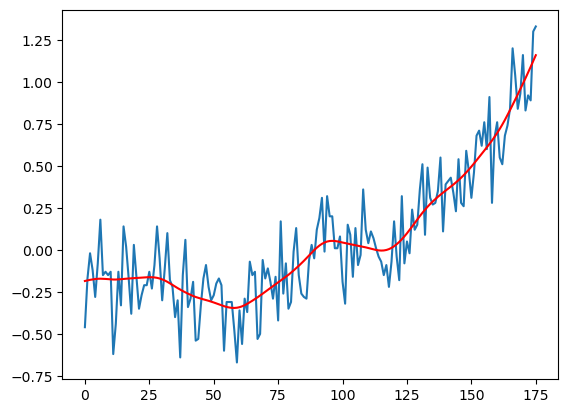

In [123]:
b_ridge = solve_ridge(X, y, lambda_val = best_lambda) 
plt.plot(y)
ridge_fitted = np.dot(X, b_ridge)
plt.plot(ridge_fitted, color = 'red')
plt.show()

### Bayesian regularization (from Lecture 12)

In the last lecture, we worked with the following prior (as a Bayesian method for regularization): 
\begin{align*}
   \beta_0, \beta_1 \overset{\text{i.i.d}}{\sim} \text{unif}(-C, C) ~~~ \beta_2, \dots, \beta_{n-1} \overset{\text{i.i.d}}{\sim} N(0, \tau^2), 
\end{align*}
We also treat $\tau$ (and $\sigma$) as unknown parameters and used the prior: 
\begin{align*}
    \log \tau, \log \sigma \overset{\text{i.i.d}}{\sim} \text{unif}(-C, C). 
\end{align*}
With this prior, the posterior for $\beta, \tau, \sigma$ can be described as follows. The posterior of $\beta$ conditional on $\sigma$ and $\tau$ is given by: 
\begin{align*}
   \beta \mid \text{data}, \sigma, \tau \sim N \left(\left(\frac{X^T
                          X}{\sigma^2} + Q^{-1}  \right)^{-1} \frac{X^T y}{\sigma^2},  \left(\frac{X^T X}{\sigma^2} + Q^{-1} \right)^{-1}\right). 
\end{align*}
where $Q$ is the diagonal matrix with diagonal entries $C, C, \tau^2, \dots, \tau^2$. Further the posterior of $\tau$ and $\sigma$ is given by: 
\begin{align*}
&  f_{\tau, \sigma \mid \text{data}}(\tau, \sigma) \\ &\propto
  \frac{\sigma^{-n-1} \tau^{-1}}{\sqrt{\det Q}}  \sqrt{\det
  \left(\frac{X^T X}{\sigma^2} + Q^{-1} \right)^{-1}} \exp \left(-\frac{y^T y}{2 \sigma^2} \right)\exp
  \left(\frac{y^T X}{2\sigma^2} \left(\frac{X^T 
  X}{\sigma^2} + 
   Q^{-1} \right)^{-1} \frac{X^T y}{\sigma^2}  \right). 
\end{align*}
We can simplify this formula slightly in order to avoid specifying $C$ explicitly using
\begin{align*} 
   \det Q  = C \times C \times \tau^2 \times \dots \times \tau^2 = C^2 \tau^{2(n-2)} \propto \tau^{2(n-2)}. 
\end{align*}
Also
\begin{align*}
   Q^{-1} = \text{diag}(1/C, 1/C, 1/\tau^2, \dots, 1/\tau^2) \approx \text{diag}(0, 0, 1/\tau^2, \dots, 1/\tau^2) = \frac{J}{\tau^2}
\end{align*}
where $J$ is the diagonal matrix with diagonals $0, 0, 1, \dots, 1$. 

Let $Q^{-1}_{\text{approx}}$ be the above diagonal matrix with diagonal entries $0, 0, 1/\tau^2, \dots, 1/\tau^2$. We shall use $Q^{-1}_{\text{approx}}$ as our proxy for $Q^{-1}$. Note that $Q^{-1}_{\text{approx}}$ does not involve any specification of $C$. With this, we rewrite the posterior of $\tau, \sigma$ as: 
\begin{align*}
&  f_{\tau, \sigma \mid \text{data}}(\tau, \sigma) \\ &\propto
  \sigma^{-n-1} \tau^{-n+1}   \sqrt{\det
  \left(\frac{X^T X}{\sigma^2} + \frac{J}{\tau^2} \right)^{-1}} \exp \left(-\frac{y^T y}{2 \sigma^2} \right)\exp
  \left(\frac{y^T X}{2\sigma^2} \left(\frac{X^T 
  X}{\sigma^2} + \frac{J}{\tau^2}
   \right)^{-1} \frac{X^T y}{\sigma^2}  \right). 
\end{align*}
Below we compute this posterior on log-scale for each value in a grid chosen for $\tau$ and $\sigma$. 


In [124]:
tau_gr = np.logspace(np.log10(0.0001), np.log10(1), 100)
sig_gr = np.logspace(np.log10(0.1), np.log10(1), 100)

t, s = np.meshgrid(tau_gr, sig_gr)

g = pd.DataFrame({'tau': t.flatten(), 'sig': s.flatten()})

for i in range(len(g)):
    tau = g.loc[i, 'tau']
    sig = g.loc[i, 'sig']
    J_by_tausq = np.diag(np.concatenate([[0, 0], np.repeat(tau**(-2), n-2)]))
    Mat = J_by_tausq + (X.T @ X)/(sig ** 2)
    Matinv = np.linalg.inv(Mat)
    sgn, logcovdet = np.linalg.slogdet(Matinv)
    g.loc[i, 'logpost'] = (-n-1)*np.log(sig) + (-n+1)*np.log(tau) + 0.5 * logcovdet - ((np.sum(y ** 2))/(2*(sig ** 2))) + (y.T @ X @ Matinv @ X.T @ y)/(2 * (sig ** 4))


The posterior samples for all the parameters can be generated as follows. 

In [125]:
g['post'] = np.exp(g['logpost'] - np.max(g['logpost']))
g['post'] = g['post']/np.sum(g['post'])

In [126]:
N = 1000
samples = g.sample(N, weights = g['post'], replace = True)
tau_samples = np.array(samples.iloc[:,0])
sig_samples = np.array(samples.iloc[:,1])
betahats = np.zeros((n, N))
muhats = np.zeros((n, N))
for i in range(N):
    tau = tau_samples[i]
    sig = sig_samples[i]
    J_by_tausq = np.diag(np.concatenate([[0, 0], np.repeat(tau**(-2), n-2)]))
    XTX = np.dot(X.T, X)
    TempMat = np.linalg.inv(J_by_tausq + (XTX/(sig ** 2)))
    XTy = np.dot(X.T, y)
    #generate betahat from the normal distribution with mean: 
    norm_mean = np.dot(TempMat, XTy/(sig ** 2)) 
    #and covariance matrix: 
    norm_cov = TempMat  
    betahat = np.random.multivariate_normal(norm_mean, norm_cov)
    muhat = np.dot(X, betahat)
    betahats[:,i] = betahat
    muhats[:,i] = muhat

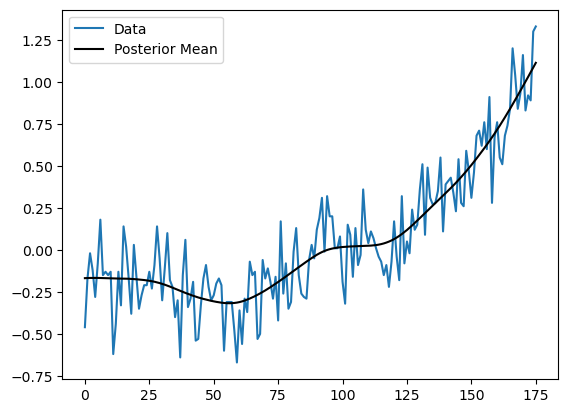

In [127]:
beta_est = np.mean(betahats, axis = 1)
mu_est = np.mean(muhats, axis = 1) #these are the fitted values

plt.plot(y, label = 'Data')
plt.plot(mu_est, color = 'black', label = 'Posterior Mean')
plt.legend()
plt.show()


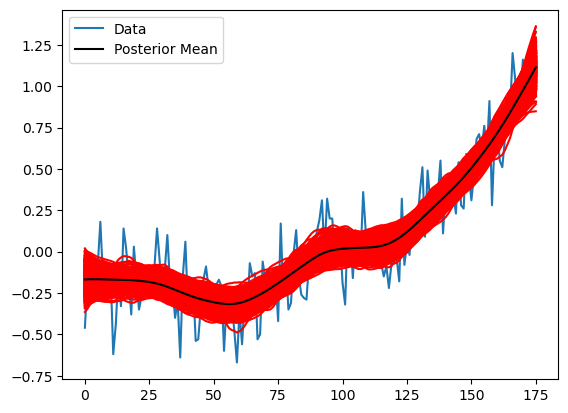

In [128]:
#Plotting all the posterior fitted values: 
plt.plot(y, label = 'Data')
for i in range(N):
    plt.plot(muhats[:,i], color = 'red')
plt.plot(mu_est, color = 'black', label = 'Posterior Mean')
plt.legend()
plt.show()


The posterior samples of $\tau$ and $\sigma$ can be visualized by their histograms. 

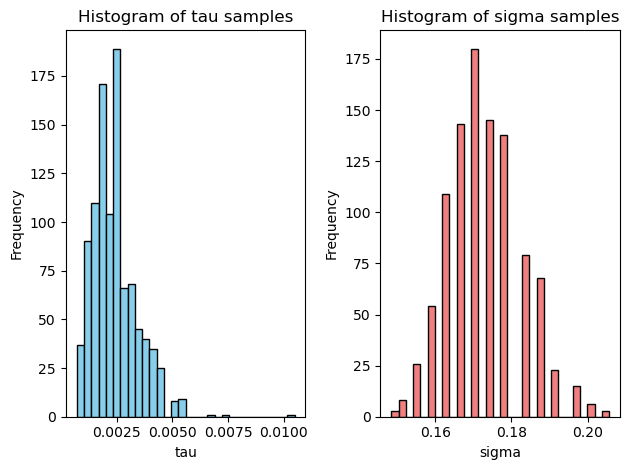

In [129]:
# First histogram: tau_samples
plt.subplot(1, 2, 1)
plt.hist(tau_samples, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of tau samples')
plt.xlabel('tau')
plt.ylabel('Frequency')

# Second histogram: sig_samples
plt.subplot(1, 2, 2)
plt.hist(sig_samples, bins=30, color='lightcoral', edgecolor='black')
plt.title('Histogram of sigma samples')
plt.xlabel('sigma')
plt.ylabel('Frequency')

# Adjust layout and show both side by side
plt.tight_layout()
plt.show()

Summary statistics of the $\tau$ and $\sigma$ samples can be obtained as follows. 

In [130]:
df_tau_sigma = pd.DataFrame({
    'tau_samples': tau_samples,
    'sig_samples': sig_samples
})

# Summary statistics
print(df_tau_sigma.describe())


       tau_samples  sig_samples
count  1000.000000  1000.000000
mean      0.002407     0.173061
std       0.000984     0.009609
min       0.000705     0.148497
25%       0.001789     0.166810
50%       0.002154     0.170735
75%       0.002848     0.178865
max       0.010476     0.205651


### Bayesian Regularization (with a slightly different prior)

Now we work with the following prior:
\begin{align*}
   \beta_0, \beta_1 \overset{\text{i.i.d}}{\sim} \text{unif}(-C, C) ~~~ \beta_2, \dots, \beta_{n-1} \overset{\text{i.i.d}}{\sim} N(0, \gamma^2 \sigma^2)
\end{align*}
We treat $\gamma$ and $\sigma$ also as unknown parameters and assign the prior: 
\begin{align*}
    \log \gamma, \log \sigma \overset{\text{i.i.d}}{\sim} \text{unif}(-C, C). 
\end{align*}
The only difference between this prior and the previous prior is that we are now parametrizing in terms of $(\gamma, \sigma)$ as opposed to $(\tau, \sigma)$ (the connection is $\tau = \sigma \gamma$). This is strictly a different prior however because under the assumption $\log \gamma, \log \sigma \overset{\text{i.i.d}}{\sim} \text{unif}(-C, C)$, the parameters $\gamma \times \sigma$ and $\sigma$ become dependent (under the prior) but the previous model assumes prior independence of $\tau$ and $\sigma$. 

The posterior of $\gamma, \sigma, \beta$ can be described as follows. 


The posterior of $\beta$ conditional on $\sigma$ and $\gamma$ is given by: 
\begin{align*}
   \beta \mid \text{data}, \sigma, \tau \sim N \left(\left(\frac{X^T
                          X}{\sigma^2} + Q^{-1}  \right)^{-1} \frac{X^T y}{\sigma^2},  \left(\frac{X^T X}{\sigma^2} + Q^{-1} \right)^{-1}\right). 
\end{align*}
where $Q$ is the diagonal matrix with diagonal entries $C, C, \gamma^2\sigma^2, \dots, \gamma^2\sigma^2$. This is the same as before. We shall again use the approximation $Q^{-1} \approx J/\tau^2 = J/(\gamma \sigma)^2$. 

We next describe the posterior of $\gamma$ and $\sigma$. Unlike the case of the previous prior, the posterior of $\sigma$ conditional on $\gamma$ can be described in closed form as: 

 \begin{equation*}
   \frac{1}{\sigma^2} \mid \text{data}, \gamma \sim \text{Gamma} \left(\frac{n}{2} - 1, \frac{y^T y - y^T X (X^T X + \gamma^{-2} J)^{-1} X^T y}{2} \right) 
 \end{equation*}
 Finally the posterior of $\gamma$ is given by: 

 \begin{align*}
   \gamma \mid \text{data} \sim \gamma^{-n+1} \sqrt{\det (X^T X + \gamma^{-2} J)^{-1}} \left(\frac{1}{y^T y - y^T X (X^T X + \gamma^{-2} J)^{-1} X^T y} \right)^{(n/2) - 1}
 \end{align*}

 We can compute this posterior on a grid of $\gamma$ values. Now we only need a 1D grid for $\gamma$ (unlike the previous model, where we needed two grids for $\tau$ and $\sigma$). 

In [131]:
gamma_gr = np.logspace(np.log10(1e-6), np.log10(1e4), 1000)
logpost_gamma = np.zeros(len(gamma_gr))

for i in range(len(gamma_gr)):
    gamma = gamma_gr[i]
    J_by_gammasq = np.diag(np.concatenate([[0, 0], np.repeat(gamma**(-2), n-2)])) 
    Mat =  X.T @ X + J_by_gammasq
    Matinv = np.linalg.inv(Mat)
    sgn, logcovdet = np.linalg.slogdet(Matinv)
    logpost_gamma[i] =(-n+1)*np.log(gamma) + 0.5 * logcovdet - (n/2 - 1)*np.log(y.T @ y - y.T @ X @ Matinv @ X.T @ y)


In [132]:
post_gamma  = np.exp(logpost_gamma - np.max(logpost_gamma))
post_gamma = post_gamma/np.sum(post_gamma)

In [133]:
postmean_gamma = np.sum(gamma_gr * post_gamma)
print(postmean_gamma)
print(1/(postmean_gamma ** 2))

0.013881161336822876
5189.773404602882


The parameter $\gamma$ is nicely connected to the tuning parameter $\lambda$ used in ridge regression. The connection is given by $\gamma = 1/\sqrt{\lambda}$ or $\lambda = 1/\gamma^2$. This is because $\lambda = \sigma^2/\tau^2$ (as we saw in Lecture 12) and $\tau = \gamma \sigma$. 

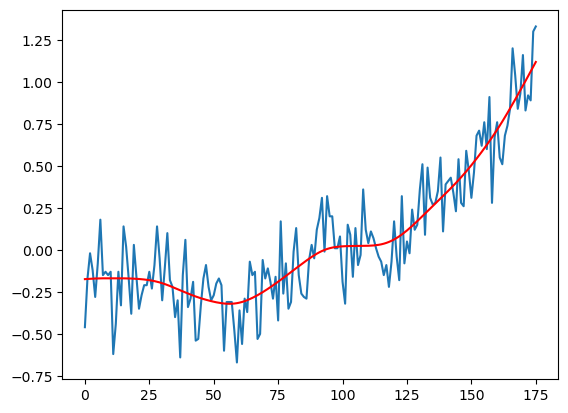

In [134]:
b_ridge = solve_ridge(X, y, lambda_val = 1/(postmean_gamma ** 2))
plt.plot(y)
ridge_fitted = np.dot(X, b_ridge)
plt.plot(ridge_fitted, color = 'red')
plt.show()

Let us draw posterior samples for all the parameters $\gamma, \sigma, \beta$. 

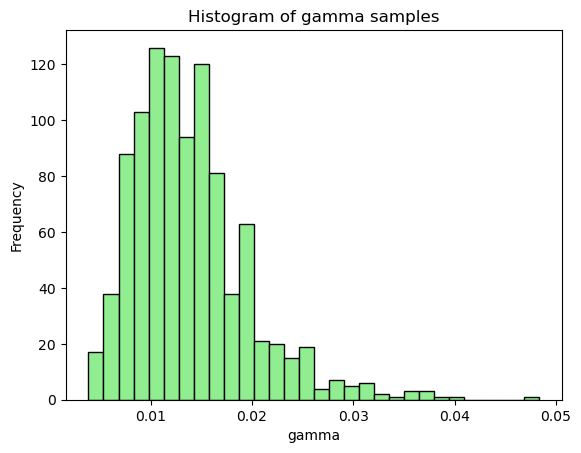

In [135]:
N = 1000
gamma_samples = np.random.choice(gamma_gr, size=N, p=post_gamma, replace=True)
plt.hist(gamma_samples, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histogram of gamma samples')
plt.xlabel('gamma')
plt.ylabel('Frequency')
plt.show()

Because of the connection between $\gamma$ and $\lambda$: $\lambda = 1/\gamma^2$, we can look at the histogram of values of $\lambda$: 

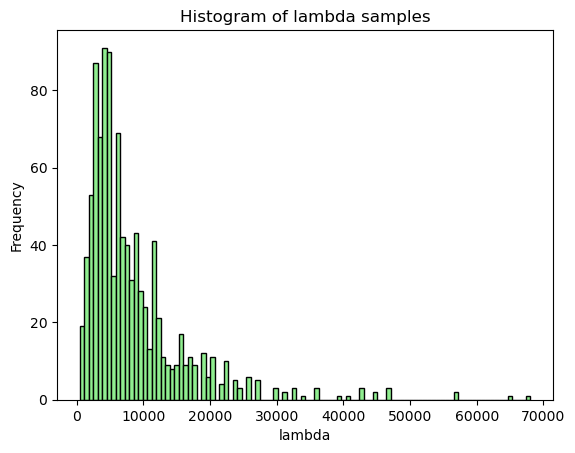

In [136]:
lambda_samples = 1/(gamma_samples ** 2)
plt.hist(lambda_samples, bins=100, color='lightgreen', edgecolor='black')
plt.title('Histogram of lambda samples')
plt.xlabel('lambda')
plt.ylabel('Frequency')
plt.show()

Here is the code for generating the samples from the other parameters. 

In [137]:
for i in range(N):
    gamma = gamma_samples[i]
    J_by_gammasq = np.diag(np.concatenate([[0, 0], np.repeat(gamma**(-2), n-2)])) 
    Mat =  X.T @ X + J_by_gammasq
    Matinv = np.linalg.inv(Mat)
    gamma_dist_lambda_parameter = (y.T @ y - y.T @ X @ Matinv @ X.T @ y)/2
    gamma_dist_alpha_parameter = n/2 - 1
    sig = np.sqrt(1/np.random.gamma(gamma_dist_alpha_parameter, 1/gamma_dist_lambda_parameter))
    sig_samples[i] = sig
    XTX = np.dot(X.T, X)
    TempMat = np.linalg.inv((J_by_gammasq/(sig ** 2)) + (XTX/(sig ** 2)))
    XTy = np.dot(X.T, y)
    #generate betahat from the normal distribution with mean: 
    norm_mean = np.dot(TempMat, XTy/(sig ** 2)) 
    #and covariance matrix: 
    norm_cov = TempMat  
    betahat = np.random.multivariate_normal(norm_mean, norm_cov)
    muhat = np.dot(X, betahat)
    betahats[:,i] = betahat
    muhats[:,i] = muhat
    

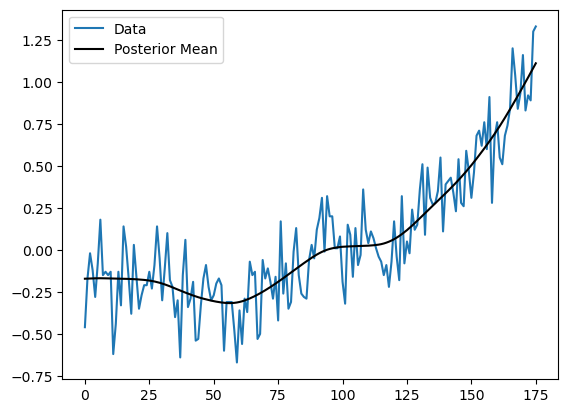

In [138]:
beta_est = np.mean(betahats, axis = 1)
mu_est = np.mean(muhats, axis = 1) #these are the fitted values

plt.plot(y, label = 'Data')
plt.plot(mu_est, color = 'black', label = 'Posterior Mean')
plt.legend()
plt.show()


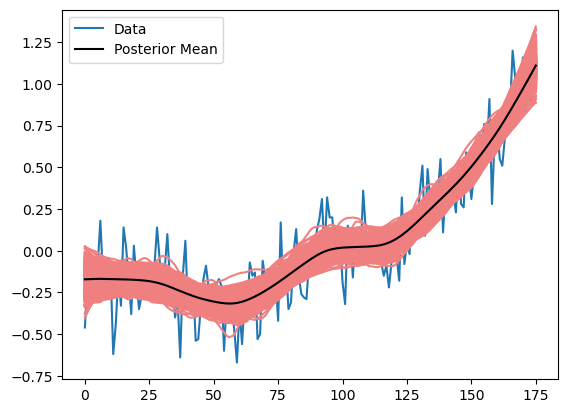

In [139]:
#Plotting all the posterior fitted values: 
plt.plot(y, label = 'Data')
for i in range(N):
    plt.plot(muhats[:,i], color = 'lightcoral')
plt.plot(mu_est, color = 'black', label = 'Posterior Mean')
plt.legend()
plt.show()


The following is the histogram of $\sigma$ values.

In [ ]:
plt.hist(sig_samples, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histogram of sigma samples')
plt.xlabel('sigma')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df_gamma_sigma = pd.DataFrame({
    'gamma_samples': gamma_samples,
    'sig_samples': sig_samples
})

# Summary statistics
print(df_gamma_sigma.describe())


## Variance Models

Next we shall study variance models (mainly in the context of spectral analysis). To illustrate the main ideas, we first consider the following simple model: 
\begin{equation*}
   y_t \overset{\text{independent}}{\sim} N(0, \tau_t^2) 
\end{equation*}
We discuss estimation of $\tau_1, \dots, \tau_n$  under the assumption that they are smooth in some sense. We shall discuss estimation next week. For now, let us simulate some data from this model to see how they look like.  

Below are two simulation settings for this variance model. 

### Simulation 1

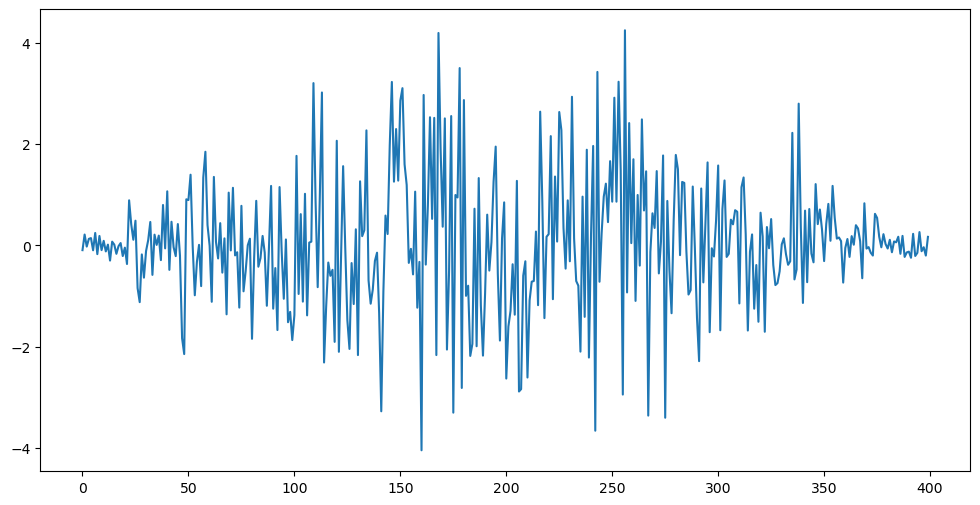

In [146]:
#Simulate data from this variance model:
n = 400
tvals = np.arange(1, n+1)
th = -0.8
tau_t = np.sqrt((1 + (th ** 2) + 2*th*np.cos(2 * np.pi * (tvals)/n))) #this is a smooth function of t
y = rng.normal(loc = 0, scale = tau_t)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

### Simulation 2

Here is the second simulation setting for this model. We take the following smooth function $\alpha_t$ and then generate $\tau_t$ as $\exp(\alpha_t)$.

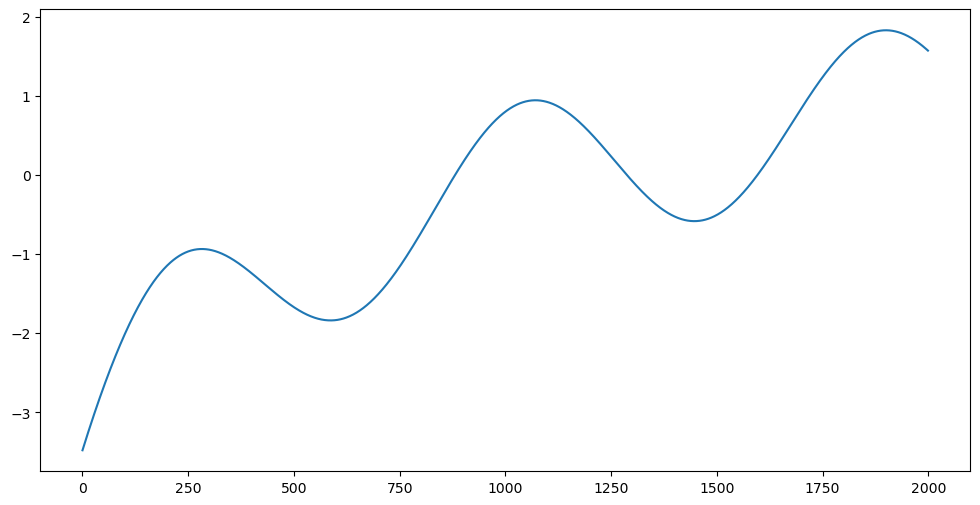

In [148]:
def smoothfun(x):
    ans = np.sin(15*x) + np.exp(-(x ** 2)/2) + 0.5*((x - 0.5) ** 2) + 2*np.log(x + 0.1)
    return ans

n = 2000
xx = np.linspace(0, 1, n)
alpha_true = np.array([smoothfun(x) for x in xx])
plt.figure(figsize = (12, 6))
plt.plot(alpha_true)
plt.show()

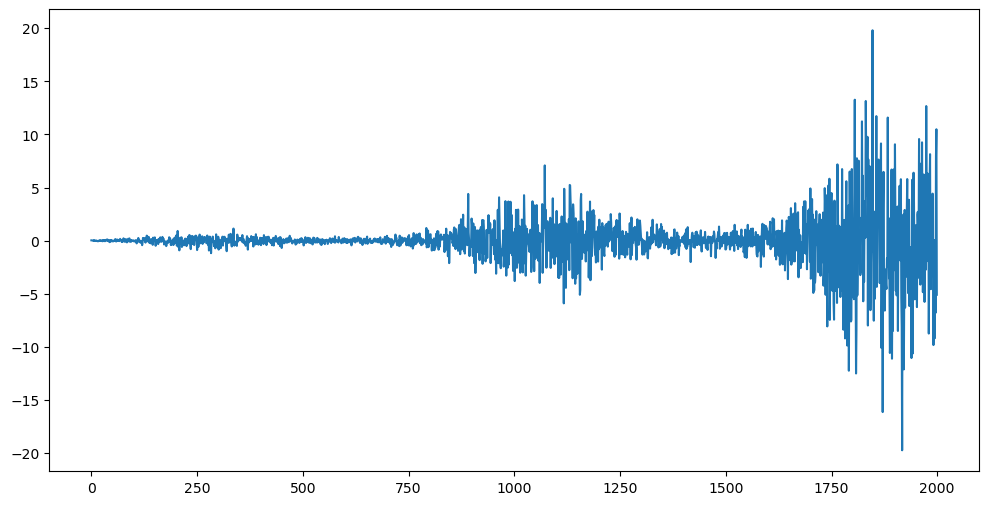

In [149]:
tau_t = np.exp(alpha_true)
y = rng.normal(loc = 0, scale = tau_t)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

Here are two common features about these simulated datasets: 
1. The data $y_1, \dots, y_n$ would oscillate around zero, with clusters of small values when $\tau_t$ is small and bursts of large values when $\tau_t$ is large. 
2. Because $\log \tau_t = \alpha_t$ is smooth, the standard deviation $\tau_t$ changes gradually, not abruptly -- so the data would exhibit smooth heteroscedasticity: periods of calm and periods of volatility, but with slow transitions. 

There exist real datasets (particularly from finance) which also display these characteristics. Below is one example. 

### A real dataset from finance for which this variance model is applicable

Next, we examine a real dataset where this variance model may be applicable. The dataset consists of stock price data for the S&P 500 mutual fund, downloaded from Yahoo Finance using the yfinance library.

In [150]:
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


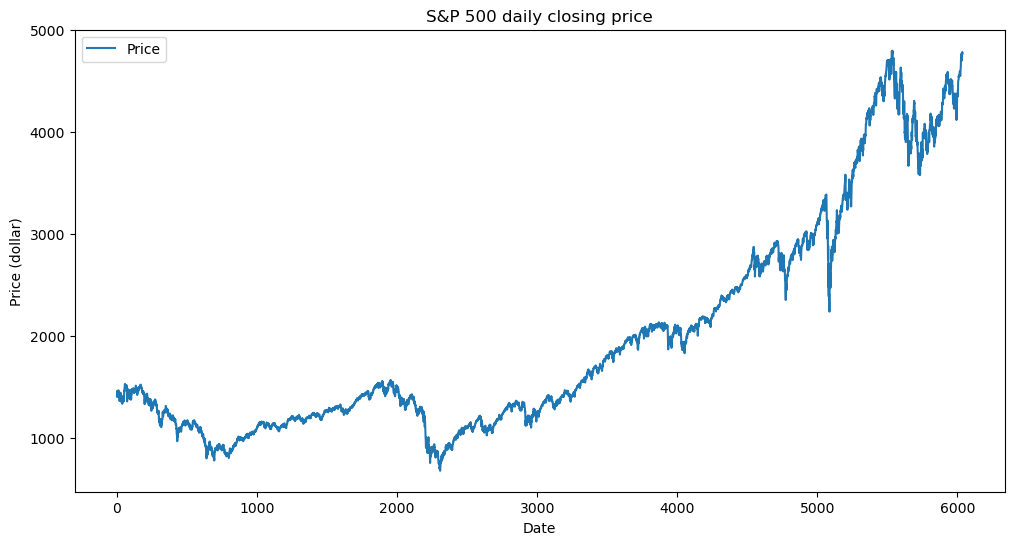

In [151]:
# Download S&P 500 data
sp500 = yf.download('^GSPC', start='2000-01-01', end='2024-01-01', auto_adjust=True)

sp500_closeprice = sp500['Close'].to_numpy().flatten() #this is the daily closing price of the S&P 500 index

plt.figure(figsize=(12,6))
plt.plot(sp500_closeprice, label="Price")
plt.xlabel("Date")
plt.title("S&P 500 daily closing price")
plt.ylabel("Price (dollar)")
plt.legend()
plt.show()


Instead of working with the prices directly, we work with percentage daily returns. 

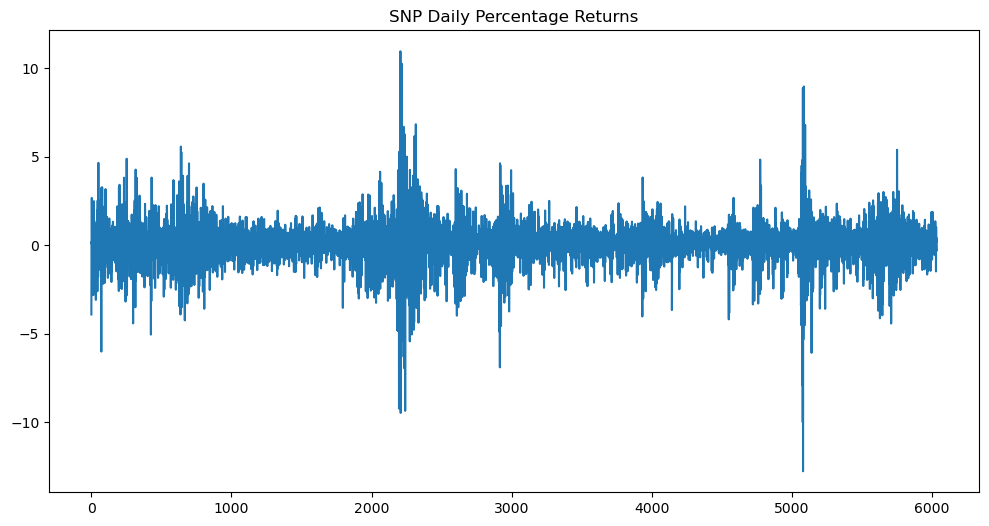

In [152]:
log_prices = np.log(sp500_closeprice)
y = 100 * np.diff(log_prices) #these are the percentage daily returns
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.title('SNP Daily Percentage Returns')
plt.show()

This clearly shares features with the simulated datasets.

We shall study estimation of $\tau_t$ from these datasets in the next lecture. 